<a href="https://colab.research.google.com/github/Champei/mine/blob/main/task2/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# 1. INSTALL DEPENDENCIES

!pip install torch torchaudio torchvision transformers tqdm matplotlib


In [4]:

# 2. MOUNT GOOGLE DRIVE & VERIFY DATA

from google.colab import drive
drive.mount('/content/drive')
import os

BASE_PATH = '/content/drive/MyDrive/Audios'

print("Subfolders (categories):", os.listdir(BASE_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subfolders (categories): ['HORN', 'INSTRUMENT', 'FOREST']


In [5]:

# 3. IMPORTS & DATASET CLASS

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio, random, matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio, display

class TrainAudioSpectrogramDataset(Dataset):
    """Loads .wav files, converts to log-mel spectrograms, returns tensor + one-hot label."""
    def __init__(self, root_dir, categories, max_frames=512, fraction=1.0):
        self.root_dir, self.categories, self.max_frames = root_dir, categories, max_frames
        self.file_list = []
        self.class_to_idx = {cat: i for i, cat in enumerate(categories)}

        for cat in categories:
            path = os.path.join(root_dir, cat)
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.wav')]
            n = int(len(files) * fraction)
            for f in random.sample(files, n):
                self.file_list.append((f, self.class_to_idx[cat]))

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        path, label = self.file_list[idx]
        wav, sr = torchaudio.load(path)
        if wav.size(0) > 1: wav = wav.mean(0, keepdim=True)
        mel = torchaudio.transforms.MelSpectrogram(sr, n_fft=1024, hop_length=256, n_mels=128)(wav)
        logmel = torch.log1p(mel)
        _, _, n_frames = logmel.shape
        logmel = F.pad(logmel, (0, max(0, 512 - n_frames)))[:, :, :512]
        y = F.one_hot(torch.tensor(label), num_classes=len(self.categories)).float()
        return logmel, y


In [6]:

# 4. MODELS

class CGAN_Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.latent_dim, self.num_classes = latent_dim, num_classes
        self.fc = nn.Linear(latent_dim + num_classes, 256 * 8 * 32)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32,1,4,2,1), nn.ReLU()
        )
    def forward(self,z,y):
        h=torch.cat([z,y],1)
        h=self.fc(h).view(-1,256,8,32)
        return self.net(h)

class CGAN_Discriminator(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.label_emb=nn.Linear(num_classes,128*512)
        self.net=nn.Sequential(
            nn.Conv2d(2,32,4,2,1), nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,4,2,1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256,1,(8,32),1,0)
        )
    def forward(self,x,y):
        ymap=self.label_emb(y).view(-1,1,128,512)
        h=torch.cat([x,ymap],1)
        return self.net(h).view(-1,1)


In [7]:
# 5. UTILITIES FOR AUDIO GENERATION & PLAYBACK

def generate_audio_gan(generator, category_idx, num_samples, device, sr=22050):
    generator.eval()
    y = F.one_hot(torch.tensor([category_idx]), num_classes=generator.num_classes).float().to(device)
    z = torch.randn(num_samples, generator.latent_dim, device=device)
    with torch.no_grad():
        logmel = generator(z, y)
    mel = torch.expm1(logmel).squeeze(1)
    invmel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=128, sample_rate=sr).to(device)
    spec = invmel(mel)
    griffin = torchaudio.transforms.GriffinLim(1024, hop_length=256, n_iter=32).to(device)
    wav = griffin(spec).cpu()
    return wav

def play_and_save(wav, sr, name):
    import torchaudio
    torchaudio.save(name, wav.squeeze(0), sr)
    print("Saved:", name)
    display(Audio(wav.numpy().squeeze(), rate=sr))


In [8]:
# 6. TRAINING FUNCTION

def train_gan(G, D, loader, device, cats, epochs, lr, latent_dim):
    optG=torch.optim.Adam(G.parameters(),lr=lr,betas=(0.5,0.999))
    optD=torch.optim.Adam(D.parameters(),lr=lr,betas=(0.5,0.999))
    loss_fn=nn.BCEWithLogitsLoss()

    os.makedirs("gan_generated_audio",exist_ok=True)
    os.makedirs("gan_spectrogram_plots",exist_ok=True)

    for ep in range(1,epochs+1):
        loop=tqdm(loader,desc=f"Epoch {ep}/{epochs}")
        for real,lab in loop:
            real,lab=real.to(device),lab.to(device)
            bs=real.size(0)
            real_y=torch.ones(bs,1,device=device)
            fake_y=torch.zeros(bs,1,device=device)

            # --- Discriminator ---
            optD.zero_grad()
            out_real=D(real,lab); lossD_real=loss_fn(out_real,real_y)
            z=torch.randn(bs,latent_dim,device=device)
            fake=G(z,lab)
            out_fake=D(fake.detach(),lab); lossD_fake=loss_fn(out_fake,fake_y)
            lossD=(lossD_real+lossD_fake); lossD.backward(); optD.step()

            # --- Generator ---
            optG.zero_grad()
            out=D(fake,lab); lossG=loss_fn(out,real_y)
            lossG.backward(); optG.step()
            loop.set_postfix(lossD=lossD.item(),lossG=lossG.item())

        # --- End-epoch visualization ---
        print(f"\nSample generation after epoch {ep}")
        fig,axs=plt.subplots(1,len(cats),figsize=(4*len(cats),4))
        if len(cats)==1: axs=[axs]
        for ci,cn in enumerate(cats):
            y=F.one_hot(torch.tensor([ci]),num_classes=len(cats)).float().to(device)
            z=torch.randn(1,latent_dim).to(device)
            with torch.no_grad(): spec=G(z,y).squeeze().cpu()
            axs[ci].imshow(spec,aspect='auto',origin='lower'); axs[ci].set_title(cn); axs[ci].axis('off')
        plt.tight_layout(); plt.savefig(f"gan_spectrogram_plots/epoch_{ep:03d}.png"); plt.show()

        for ci,cn in enumerate(cats):
            wav=generate_audio_gan(G,ci,1,device)
            play_and_save(wav,22050,f"gan_generated_audio/{cn}_ep{ep}.wav")


In [12]:
!apt install ffmpeg -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [13]:
import os

base_dir = '/content/drive/MyDrive/Audios'

for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.lower().endswith('.mp3'):
            mp3_path = os.path.join(root, f)
            wav_path = os.path.splitext(mp3_path)[0] + '.wav'

            # Only convert if WAV doesn't exist yet
            if not os.path.exists(wav_path):
                print(f"Converting: {mp3_path}")
                !ffmpeg -y -i "{mp3_path}" -ar 22050 -ac 1 "{wav_path}"


Converting: /content/drive/MyDrive/Audios/HORN/mega-horn-398654.mp3
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libt

In [14]:
for cat in os.listdir(base_dir):
    cat_path = os.path.join(base_dir, cat)
    if os.path.isdir(cat_path):
        wavs = [f for f in os.listdir(cat_path) if f.endswith('.wav')]
        print(f"{cat}: {len(wavs)} wav files")


HORN: 5 wav files
INSTRUMENT: 5 wav files
FOREST: 5 wav files


Categories: ['FOREST', 'HORN', 'INSTRUMENT']


Epoch 1/50:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/aud


Sample generation after epoch 1


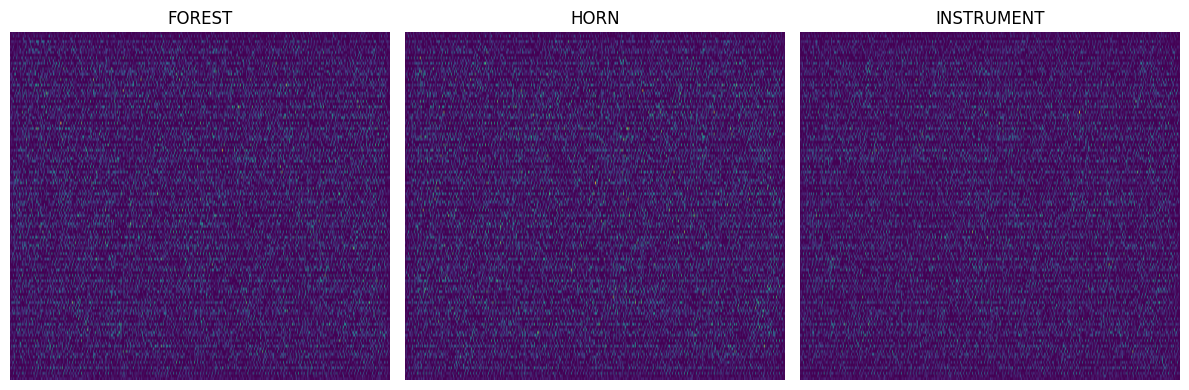

_LinAlgError: torch.linalg.lstsq: The least squares solution could not be computed because the input matrix does not have full rank (error code: 3).

In [15]:
train_path = '/content/drive/MyDrive/Audios'
cats = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print("Categories:", cats)

ds = TrainAudioSpectrogramDataset(train_path, cats)
dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=2)

G = CGAN_Generator(LATENT_DIM, len(cats)).to(DEVICE)
D = CGAN_Discriminator(len(cats)).to(DEVICE)

train_gan(G, D, dl, DEVICE, cats, EPOCHS, LR, LATENT_DIM)
